# Boreal Height Prediction with CMIP6
### ICESat-2 ATL08 training data assembly
filtering, aggregating, cleaning

In [2]:
import sys
sys.path.append('/home/pmontesa/code/geoscitools')
import atl08lib
import maplib
import pandas as pd
import geopandas as gpd
import csv
import numpy as np

import os
os.sys.path.append('/home/pmontesa/code/icesat2')
import FilterUtils
import contextily as ctx
%matplotlib inline
from plotnine import *

/panfs/ccds02/home/pmontesa/code/geoscitools/atl08lib.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Define clip extent
Unions, dissolves, buffer, to get a clip extent and an extent in which data will be zero'd out   
Bbox + Continent + Continuous Permafrost Domain + Boreal Domain

#### Creat bbox polygon gdf

In [3]:
def make_bbox_gdf(bbox=[-180, 45, 180, 75]):
    import geopandas as gpd
    from shapely.geometry import Point, Polygon

    p1 = Point(bbox[0], bbox[3])
    p2 = Point(bbox[2], bbox[3])
    p3 = Point(bbox[2], bbox[1])
    p4 = Point(bbox[0], bbox[1])

    np1 = (p1.coords.xy[0][0], p1.coords.xy[1][0])
    np2 = (p2.coords.xy[0][0], p2.coords.xy[1][0])
    np3 = (p3.coords.xy[0][0], p3.coords.xy[1][0])
    np4 = (p4.coords.xy[0][0], p4.coords.xy[1][0])

    bb_polygon = Polygon([np1, np2, np3, np4])

    bbox_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bb_polygon), columns=['geometry'], crs=4326)
    
    return bbox_gdf



In [4]:
EXT_NORTH_AMERICA = [-169, 45, -50, 75]
EXT_EURASIA = [-10, 45, 180, 75]

EXT_DICT = {'REALM': ['Palearctic', 'Nearctic'], 
            'EXTENT': [EXT_EURASIA, EXT_NORTH_AMERICA], 
            'CONTINENTS_LIST': [['Asia', 'Europe'], ['North America']],
            'EXTENT_CONT_CLIP': [],
            'EXTENT_PERM_CLIP': [],
            'EXTENT_BOREAL_BUF_CLIP': [],
            'EXTENT_BOREAL_BUF_CLIP_UNION': [],
            'EXTENT_FINAL': []
           }

### Buffer boreal

In [5]:
BUF_DIST = 1e5
print(f' Buffer distance (km): {int(BUF_DIST/1000)}')

 Buffer distance (km): 100


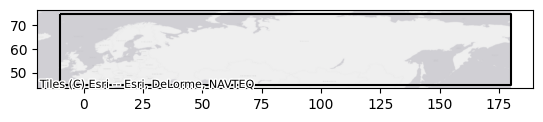

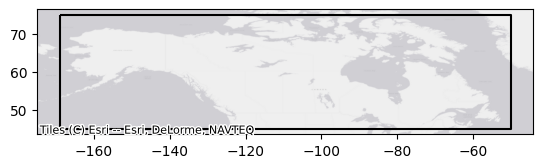

In [6]:
for EXT in EXT_DICT['EXTENT']:
    bbox_gdf = make_bbox_gdf(bbox = EXT)
    
    ax_main = bbox_gdf.boundary.plot(color='black')
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
                source = ctx.providers.Esri.WorldGrayCanvas
            )

In [7]:
continents_gdf = gpd.read_file('/panfs/ccds02/nobackup/people/pmontesa/userfs02/arc/continents.shp')

Explode the continents layer and find the continental polygon (the largest).   
This will effectively exclude the non-continental (islands) of the Canadian High Arctic

In [8]:
continents_gdf.head()
g = continents_gdf.groupby('CONTINENT')
g.groups.keys()

dict_keys(['Africa', 'Antarctica', 'Asia', 'Australia', 'Europe', 'North America', 'Oceania', 'South America'])

/tmp/ipykernel_3753760/3585937967.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_3753760/3585937967.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


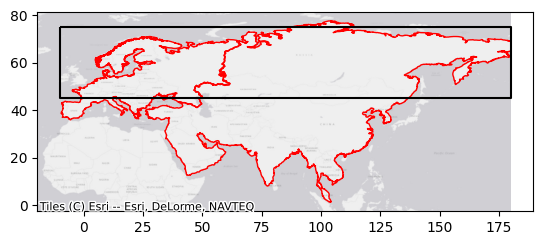

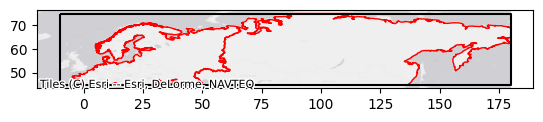

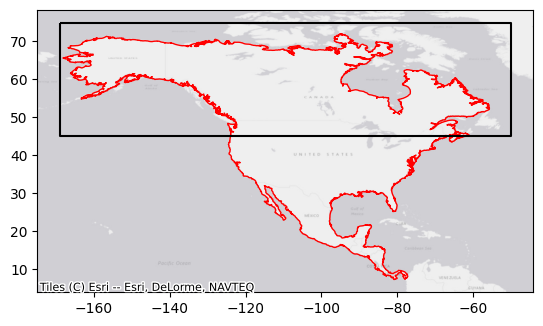

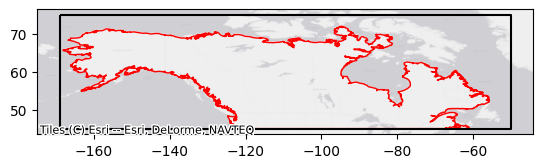

In [9]:
EXT_DICT['EXTENT_CONT_CLIP'] = []
for i, CONTINENTS_LIST in enumerate(EXT_DICT['CONTINENTS_LIST']):
    
    # This explode() step sets up the area selection step that limits us to mainlands
    # Note 3e6 area thresh removes Greenland
    sub_conts_gdf = continents_gdf[continents_gdf['CONTINENT'].isin(CONTINENTS_LIST)].explode()
    sub_conts_gdf['area_km2'] = sub_conts_gdf.to_crs(3995).area / 10**6
    sub_conts_gdf = sub_conts_gdf[sub_conts_gdf.area_km2 > 3e6].cx[EXT_DICT['EXTENT'][i][0]:EXT_DICT['EXTENT'][i][2], 45:75]

    bbox_gdf = make_bbox_gdf(bbox = EXT_DICT['EXTENT'][i])
    
    ax_main = bbox_gdf.boundary.plot(color='black')
    ax_main = sub_conts_gdf.plot(ax=ax_main, color='none', ec='red')
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
                source = ctx.providers.Esri.WorldGrayCanvas
            )
    
    sub_conts_gdf_clip = gpd.overlay(sub_conts_gdf, bbox_gdf, how='intersection')
    
    ax_main = bbox_gdf.boundary.plot(color='black')
    ax_main = sub_conts_gdf_clip.plot(ax=ax_main, color='none', ec='red')
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
                source = ctx.providers.Esri.WorldGrayCanvas
            )
    EXT_DICT['EXTENT_CONT_CLIP'].append(sub_conts_gdf_clip)

In [10]:
# https://databasin.org/datasets/1f624a31ab224835a78ad4bf11103419/
perma = gpd.read_file('/explore/nobackup/people/pmontesa/userfs02/arc/permaice_extent.gpkg')
perma['NUM_CODE'] = pd.to_numeric(perma['NUM_CODE'])
perma["area_km2"] = perma['geometry'].to_crs(3995).area/ 10**6

In [11]:
boreal_gdf = gpd.read_file('/explore/nobackup/people/pmontesa/userfs02/arc/wwf_circumboreal_Dissolve.shp').to_crs(4326)

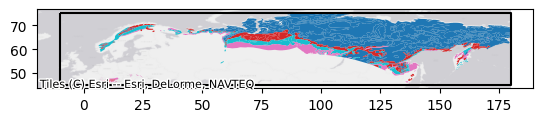

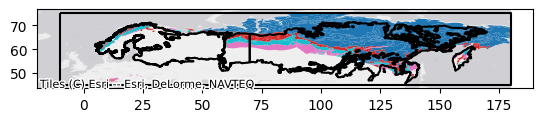

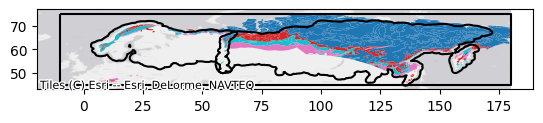

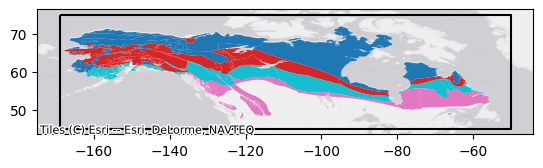

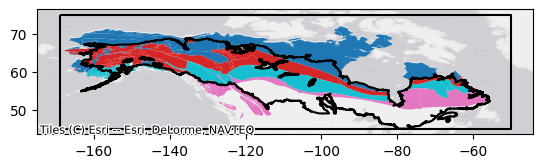

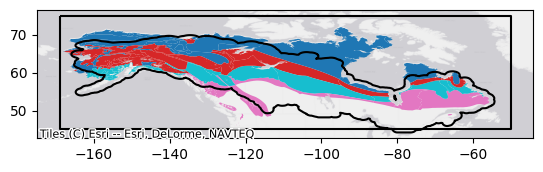

In [12]:
EXT_DICT['EXTENT_PERM_CLIP'] = []
EXT_DICT['EXTENT_BOREAL_BUF_CLIP'] = []
for i, GDF_CONT in enumerate(EXT_DICT['EXTENT_CONT_CLIP']):
    
    perma_clip = gpd.overlay(perma, GDF_CONT.to_crs(perma.crs), how='intersection')
    EXT_DICT['EXTENT_PERM_CLIP'].append(perma_clip)
    bbox_gdf = make_bbox_gdf(bbox = EXT_DICT['EXTENT'][i])
    
    ax_main = perma_clip.to_crs(4326).plot(column='EXTENT')
    ax_main = bbox_gdf.boundary.plot(color='black', ax=ax_main)
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas             
        )
    
    boreal_gdf_clip = gpd.overlay(boreal_gdf, GDF_CONT.to_crs(boreal_gdf.crs), how='intersection')
    ax_main = perma_clip.to_crs(4326).plot(column='EXTENT')
    ax_main = bbox_gdf.boundary.plot(color='black', ax=ax_main)
    ax_main = boreal_gdf_clip.boundary.plot(color='black', ax=ax_main)
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
                source = ctx.providers.Esri.WorldGrayCanvas
            )
    
    tmp = boreal_gdf_clip.to_crs(3995)
    tmp['geometry'] = tmp.geometry.buffer(BUF_DIST)
    boreal_gdf_clip_buf = tmp.to_crs(4326)
    
    
    ax_main = perma_clip.to_crs(4326).plot(column='EXTENT')
    ax_main = bbox_gdf.boundary.plot(color='black', ax=ax_main)
    ax_main = boreal_gdf_clip_buf.boundary.plot(color='black', ax=ax_main)
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
                source = ctx.providers.Esri.WorldGrayCanvas
            )
    
    #boreal_gdf_clip_buf = EXT_DICT['EXTENT_BOREAL_BUF_CLIP'][i]
    boreal_gdf_clip_buf = boreal_gdf_clip_buf.drop(columns=['Shape_Leng', 'Shape_Area', 'area_km2'])
    #boreal_gdf_clip_buf = boreal_gdf_clip_buf.drop(columns=['Shape_Leng', 'Shape_Area', 'area_km2'])
    realm = EXT_DICT['REALM'][i]
    boreal_gdf_clip_buf['REALM'] = realm
    
    EXT_DICT['EXTENT_BOREAL_BUF_CLIP'].append(boreal_gdf_clip_buf)
    boreal_gdf_clip_buf.to_file(f'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height_cmip/wwf_circumboreal_Dissolve_{realm}_buf{int(BUF_DIST/1000)}km.gpkg', driver='GPKG')

In [13]:
# tmp = boreal_gdf_clip.to_crs(3995)
# tmp['geometry'] = tmp.geometry.buffer(BUF_DIST)
# boreal_gdf_clip_buf = tmp.to_crs(4326)

In [1]:
# ax_main = perma_clip.to_crs(4326).plot(column='EXTENT')
# ax_main = bbox_gdf.boundary.plot(color='black', ax=ax_main)
# ax_main = boreal_gdf_clip_buf.boundary.plot(color='black', ax=ax_main)
# ax_main = ctx.add_basemap(ax_main, crs=4326, 
#             source = ctx.providers.Esri.WorldGrayCanvas
#         )

In [3]:
#boreal_gdf_clip_buf.head()

# Finalize the Boreal Height CMIP6 Extent

## Union, classify, and dissolve to get final clip vector
*Boreal extent + all permafrost in continental North America*

#### Union

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/geopandas/geodataframe.py:2323: UserWarning: `keep_geom_type=True` in overlay resulted in 4011 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


CPU times: user 3min 33s, sys: 1.58 s, total: 3min 35s
Wall time: 3min 25s


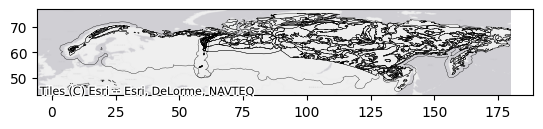

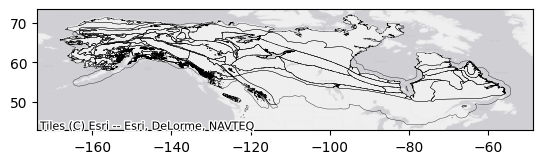

In [14]:
%%time
for i, REALM in enumerate(EXT_DICT['REALM']):
    
    perma_clip = EXT_DICT['EXTENT_PERM_CLIP'][i]
    boreal_gdf_clip_buf = EXT_DICT['EXTENT_BOREAL_BUF_CLIP'][i]
    
    # Boreal extent + all permafrost in continental North America
    boreal_gdf_clip_buf_perm = boreal_gdf_clip_buf.to_crs(4326).overlay(perma_clip.to_crs(4326), how='union')
    ax_main = boreal_gdf_clip_buf_perm.boundary.plot(ec='k', linewidth=0.25)
    ax_main = ctx.add_basemap(ax_main, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )
    boreal_gdf_clip_buf_perm.to_file(f'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height_cmip/wwf_circumboreal_Dissolve_{REALM}_buf{int(BUF_DIST/1000)}km_PERMEXTENT.gpkg', driver='GPKG')

In [15]:
boreal_gdf_clip_buf_perm.tail()

,OBJECTID,REALM,CONTINENT_1,NUM_CODE,COMBO,RELICT,EXTENT,CONTENT,LANDFORM,area_km2_1,CONTINENT_2,area_km2_2,geometry
1330,NaN,NaN,NaN,17.0,Clr,None,C,l,r,1464.513906,North America,2.741632e+07,"POLYGON ((-106.80969 68.40561, -106.91899 68.3..."
1331,NaN,NaN,NaN,1.0,Chf,None,C,h,None,285818.060662,North America,2.741632e+07,"MULTIPOLYGON (((-114.77055 68.76944, -114.7583..."
1332,NaN,NaN,NaN,1.0,Chf,None,C,h,None,9164.018003,North America,2.741632e+07,"POLYGON ((-81.28969 67.42320, -81.45025 67.476..."
1333,NaN,NaN,NaN,1.0,Chf,None,C,h,None,5.298096,North America,2.741632e+07,"POLYGON ((-82.51633 69.51617, -82.50823 69.513..."
1334,NaN,NaN,NaN,17.0,Clr,None,C,l,r,1.608619,North America,2.741632e+07,"POLYGON ((-89.05291 63.95986, -89.03555 63.946..."


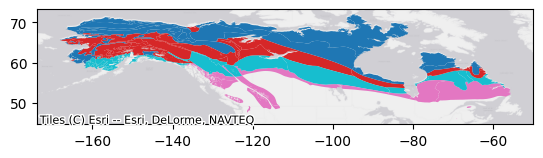

In [78]:
ax_main = boreal_gdf_clip_buf_perm.plot(column='EXTENT', linewidth=0.25)
ax_main = ctx.add_basemap(ax_main, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

#### Classify, Dissolve, Save
the continuous permafrost extent that is not within the 100 km buffer of the boreal is where canopy height values from ATL08 will be set to 0.

In [25]:
EXT_DICT['EXTENT_FINAL'] = []
DIR_PROJ = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height_cmip'
for REALM in EXT_DICT['REALM']:
    EXTENT_FN = f"{DIR_PROJ}/boreal_height_cmip_extent_{REALM}.gpkg"
    boreal_gdf_clip_buf_perm = gpd.read_file(f'{DIR_PROJ}/wwf_circumboreal_Dissolve_{REALM}_buf{int(BUF_DIST/1000)}km_PERMEXTENT.gpkg', driver='GPKG')
    condition = ((boreal_gdf_clip_buf_perm.REALM.isnull()) & (boreal_gdf_clip_buf_perm.EXTENT == 'C'))

    boreal_gdf_clip_buf_perm['height_class'] = np.where(condition, 'h_can to 0', 'h_can')
    
    extent_dis = boreal_gdf_clip_buf_perm.dissolve(by='height_class').reset_index()
    
    extent_dis = extent_dis[['geometry','height_class']]

    extent_dis.to_file(EXTENT_FN, driver='GPKG')
    extent_dis.explode().to_file(f"{DIR_PROJ}/boreal_height_cmip_extent_polygons_{REALM}.gpkg", driver='GPKG')

/tmp/ipykernel_3753760/1435200239.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
/tmp/ipykernel_3753760/1435200239.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


### Might need to explode() the MultiPolygons into individual polygons

In [23]:
extent_dis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geometry      2 non-null      geometry
 1   height_class  2 non-null      object  
dtypes: geometry(1), object(1)
memory usage: 160.0+ bytes


In [22]:
extent_dis.explode().info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 47 entries, (0, 0) to (1, 31)
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   height_class  47 non-null     object  
 1   geometry      47 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 2.3+ KB


/tmp/ipykernel_3753760/1037885407.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


In [24]:
# extent_dis.explore(column='height_class', cmap='RdYlBu', 
#                    tiles = 'https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#                    #tiles = 'http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}',
#                    attr =' ')

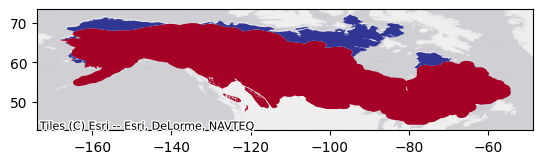

In [57]:
ax_main = extent_dis.plot(column='height_class', cmap='RdYlBu')
ax_main = ctx.add_basemap(ax_main, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

/tmp/ipykernel_475595/1192552896.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


# Intersect with clip vector
**TODO** this crashes the kernel - size? the approach works on smaller datasets

#### Build ATL08 geodataframe from extracted CSVs that were heavily filtered with land-cover specific thresholds for h_can (canopy height)

In [3]:
SITENAME = 'boreal_na_20m'
minYEAR = 2022
maxYEAR = 2022

# Filter: using NEW land cover specific thresholds

In [4]:
class_thresholds_hcan =     [0,60,60,60,60,60,60,50,50,50,50,50,50,20,10,10,5,5,0,0,0,0,0]
class_thresholds_hcan_new = [0,60,60,60,60,60,60,50,50,50,50,50,50, 5, 5, 5,5,5,0,0,0,0,0]


class_values = [ 0, 111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 30, 90, 100, 60, 40, 50, 70, 80, 200] 
class_names = ['No data', 'Closed forest\nevergreen needle', 'Closed forest\ndeciduous needle', 'Closed forest\nevergreen broad', 'Closed forest\ndeciduous broad', 'Closed forest\nmixed', 'Closed forest\nunknown', 
               'Open forest\nevergreen needle', 'Open forest\ndeciduous needle', 'Open forest\nevergreen_broad', 'Open forest\ndeciduous_broad', 'Open forest\nmixed', 'Open forest\nunknown', 'Shrubs', 'Herbaceous', 
               'Herbaceous\nwetleand', 'Moss/lichen', 'Bare/sparse', 'Cultivated/managed', 'Urban/built', 'Snow/ice', 'Permanent\nwater', 'Open sea']

# Make dicts
landcover_remap_dict = dict(zip(class_values, class_names))
threshold_remap_dict = dict(zip(class_names, class_thresholds_hcan_new))
dict_lc_h_can_thresh = dict(zip(class_values, class_thresholds_hcan_new))

# Read, Intersect, Filter, Save

In [5]:
%%time
main_dir = f'/explore/nobackup/people/pmontesa/userfs02/data/icesat2/atl08.005/{SITENAME}'

# Read, Intersect
atl08_gdf = pd.concat([atl08lib.atl08_io(main_dir, str(YEAR), DO_PICKLE=False, LENGTH_SEG=20, INTERSECT=EXTENT_FN) for YEAR in range(minYEAR, maxYEAR+1)])

#bname1 = os.path.basename(main_dir)
#dirname1 = os.path.basename(main_dir)
#atl08_gdf.to_file(os.path.join(main_dir, dirname1 + bname1 + '.gpkg'), driver='GPKG')

# Filter with NEW dicts
atl08_gdf = pd.concat([atl08_gdf[(atl08_gdf.seg_landcov == lc) & (atl08_gdf.h_can_20m < thresh_h_can)] for lc, thresh_h_can in dict_lc_h_can_thresh.items()])

# Save
out_parquet_fn = f"/explore/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height_cmip/atl08_{SITENAME}_intersect_filt_{minYEAR}_{maxYEAR}.parquet"
atl08_gdf.to_parquet(out_parquet_fn) 

print(f'/n{out_parquet_fn}')

atl08_gdf.info()

Building list of ATL08 csvs...
593
Creating pandas data frame...
Concatenating multiple gdfs for 2022 @ 20m...
/n/explore/nobackup/people/pmontesa/userfs02/projects/ilab/boreal_height_cmip/atl08_boreal_na_20m_intersect_filt_2022_2022.parquet
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4248609 entries, 0 to 4492789
Data columns (total 26 columns):
 #   Column        Dtype   
---  ------        -----   
 0   id_unique     object  
 1   lon           float64 
 2   lat           float64 
 3   h_can_20m     float64 
 4   lon_100m      float64 
 5   lat_100m      float64 
 6   h_can         float64 
 7   h_max_can     float64 
 8   h_te_best     float64 
 9   rh25          float64 
 10  rh50          float64 
 11  rh60          float64 
 12  rh70          float64 
 13  rh75          float64 
 14  rh80          float64 
 15  rh90          float64 
 16  seg_landcov   int64   
 17  seg_cover     int64   
 18  sol_el        float64 
 19  dt            object  
 20  granule_name  ob

In [ ]:
# %%time
# test_atl08_gdf = gpd.overlay(atl08_gdf.head(int(1e4)), extent_dis, how='intersection')
# test_atl08_gdf.head()

In [ ]:
# intersect_geometry = boreal_continuous_perm_dis.iloc[0].geometry

# # Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
# selector_intersect = atl08_gdf.to_crs(4326).intersects(intersect_geometry)
# atl08_gdf = atl08_gdf.to_crs(4326)[selector_intersect]
# atl08_gdf.info()

##### Subset columns

In [16]:
# atl08_gdf = atl08_gdf[['lon', 'lat', 'h_can_20m', 'height_class']]

In [15]:
# %%time
# SAMP_FRAC=1
# maplib.MAP_ATL08_FOLIUM(atl08_gdf.cx[-146.20:-146.18, 69.31267:69.32335].sample(frac=SAMP_FRAC), MAP_COL='h_can_20m', GROUP_COL='y', DO_NIGHT=False, RADIUS=3)

In [ ]:
#atl08_gdf['seg_landcov'].replace(landcover_remap_dict, inplace=True)
#atl08_gdf_sub['seg_landcov_names'] = atl08_gdf_sub['seg_landcov'].replace(landcover_remap_dict)

In [ ]:
#gpd.overlay(, INTERSECT.to_crs(4326), how='intersection')

# Map

In [ ]:
atl08_gdf_sub.sample(frac=0.01).explore(column='height_class', cmap='RdYlBu', 
                   tiles = 'https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                   #tiles = 'http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}',
                   attr =' ')

In [ ]:
%%time
SAMP_FRAC=0.01
maplib.MAP_ATL08_FOLIUM(atl08_gdf_sub.cx[-130:-128, 66:70].sample(frac=SAMP_FRAC), MAP_COL='h_can_20', GROUP_COL='y', DO_NIGHT=False, RADIUS=3)
#maplib.MAP_ATL08_FOLIUM(atl08_gdf_sub.sample(frac=SAMP_FRAC), MAP_COL='h_can_20m', GROUP_COL='y', DO_NIGHT=False, RADIUS=3)